## Excel "What if?" analysis with Python - Part 3: Monte-carlo simulation


In the [first part of this series](http://hselab.org/excel-to-python-1-models-datatables.html), I introduced the general idea of exploring using Python for typical spreadsheet modeling activities. We built both object-oriented (OO) and non-OO versions of a basic business model (the Bookstore Model - it's repeated below for convenience) and learned a few things about doing OOP in Python. Then we designed and created a `data_table` function to do sensitivity analysis much like Excel's Data Table tool (though our Python version can handle an arbitrary number of both input and output variables). In [part 2 we created a goal_seek function](http://hselab.org/excel-to-python-2-goalseek.html) that is reminiscent of Excel's Goal Seek tool. 

Now it's time to add Monte-Carlo simulation capabilities to our little library of functions. We'll stick with the same example. We are getting to the point where it would be convenient to package up our `BookstoreModel` class along with the `data_table` and `goal_seek` functions so that we could import them and use them here. I'll hold off on that until the next installment. For now, I've just included the code. In the spirit of consistency with the first two posts, we'll once again look at both OO and non-OO approaches to this problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection._search import ParameterGrid
import seaborn as sns
import copy

In [2]:
%matplotlib inline

## Bookstore model

This example is based on one in the [spreadsheet modeling textbook(s) I've used in my classes since 2001](https://host.kelley.iu.edu/albrightbooks/). I started out using Practical Management Science by Winston and Albright and switched to their Business Analytics: Data Analysis and Decision Making (Albright and Winston) around 2013ish. In both books, they introduce the "Walton Bookstore" problem in the chapter on Monte-Carlo simulation. Here's the basic problem (with a few modifications):

* we have to place an order for a perishable product (e.g. a calendar),
* there's a known unit cost for each one ordered,
* we have a known selling price,
* demand is uncertain but we can model it with some simple probability distribution,
* for each unsold item, we can get a partial refund of our unit cost,
* we need to select the order quantity for our one order for the year; orders can only be in multiples of 25.


## A non-OO approach to Monte-Carlo simulation
Let's start by repeating our basic non-OO model code for setting inputs and computing profit.

In [3]:
# Set all of our base input values except demand
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
order_quantity = 200

In [4]:
def bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand) * unit_refund
    profit = sales_revenue + refund_revenue - order_cost
    return profit

### Generating random demand values
Assume we've used historical data to estimate the mean and standard deviation of demand. Furthermore, let's pretend that a histogram revealed a relatively normal looking distribution. 

In [5]:
# Demand parameters
demand_mean = 193
demand_sd = 40

We can generate a vector of random demand realizations and then feed that vector to our `compute_profit` function. The result will be a vector of profits with the same number of elements as in our demand vector. Then we can analyze the results using descriptive statistics and plotting.

Recently, numpy has updated their random variable generation routines. The details are at https://numpy.org/doc/stable/reference/random/index.html.

The `scipy.stats` module contains a large number of probability distributions and each has numerous functions for calculating things such as pdf or CDF values, quantiles, and various moments. You can see the details at https://docs.scipy.org/doc/scipy/reference/stats.html.

Let's assume we want to model demand with a normal distribution. We already initialized variables `demand_mean` and `demand_sd` with the mean and standard deviation of demand. 

The plan:

* import random number generation function from numpy,
* initialize a random number generator object,
* use numpy's `normal` function to generate normally distributed random variates (we'll do 1000),
* compute basic summary stats for the generated random variates,
* create a histogram of the generated random variates to make sure they look normal (they will),
* use `scipy.stats.norm` to create a normal distribution object,
* use that normal distribution object to overlay a normal density curve on our histogram.

In [6]:
print(f"Demand mean = {demand_mean}")
print(f"Demand sd = {demand_sd}")

Demand mean = 193
Demand sd = 40


Before we launch into this, let's consider something that modelers often do with uncertain quantities - they simply replace them with their mean. As a benchmark, let's see what we'd estimate profit to be if we simply used the value of `demand_mean`. Remember this number.

In [7]:
deterministic_profit = bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, demand_mean)
deterministic_profit

447.5

First we need to import the default random number generator and create a random generator variable. I'll use 4470 as the seed. This generator generates numbers uniformly between 0 and 1, which can be used to generate random variates from whatever distribution we choose.

In [8]:
from numpy.random import default_rng
rg = default_rng(4470)
rg.random() # Generate one just to see it work

0.45855804438027437

Generate 1000 random variates from a normal distribution with our given mean and standard deviation.

In [9]:
demand_sim = rg.normal(demand_mean, demand_sd, 1000)

Obviously we are generating variates from a continuous distribution.

In [10]:
demand_sim[:10]

array([217.03616307, 133.37168121, 231.54405167, 215.05711803,
       183.66669223, 268.28497816, 255.99191635, 188.58125604,
       164.62174798, 170.1384389 ])

If we want integer valued demands, we can simply round the values.

In [11]:
demand_sim = np.around(rg.normal(demand_mean, demand_sd, 1000))
demand_sim[:10]

array([218., 203., 186., 203., 215., 151., 255., 176., 223., 252.])

Before plotting the histogram, let's compute basic summary stats for our vector of random demands.

In [12]:
print(f"Mean demand = {demand_sim.mean():.3f}, Std dev demand = {demand_sim.std():.3f}")

Mean demand = 192.056, Std dev demand = 40.170


Now use SciPy to create a normal random variable instance with the mean and standard deviation based on `demand_mean` and `demand_sd`. Note the data type. Then we'll be able to use its built in `pdf` method to plot its density and its `ppf` method to get percentiles to use for our x-axis limits.

In [13]:
from scipy.stats import norm

In [14]:
rv_normal = norm(loc=demand_mean, scale=demand_sd)
print(type(rv_normal))

<class 'scipy.stats._distn_infrastructure.rv_frozen'>


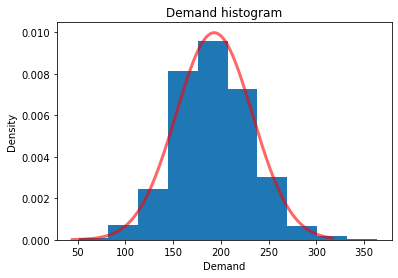

In [15]:
plt.title("Demand histogram")
plt.xlabel("Demand")
plt.ylabel("Density")
plt.hist(demand_sim, density=True);

x_normal = np.linspace(rv_normal.ppf(0.0001),
                rv_normal.ppf(0.999), 500)

plt.plot(x_normal, rv_normal.pdf(x_normal),
       'r-', lw=3, alpha=0.6, label='Normal pdf');

### Running the simulation

Now that we can generate random demands, we can simulate by simply passing in the vector of random demands to the `compute_profit` function - all the other model inputs are held fixed at their current values. Let's remind ourselves of these values.

In [16]:
message = f"unit_cost: {unit_cost} \n" \
          f"selling_price: {selling_price} \n" \
          f"unit_refund: {unit_refund} \n" \
          f"order_quantity: {order_quantity}"

print(message)

unit_cost: 7.5 
selling_price: 10.0 
unit_refund: 2.5 
order_quantity: 200


We use a list comprehension to evaluate profit for each demand realization. This is exactly the same way we did [the non-OO 1-way data table in the first part of this series](https://render.githubusercontent.com/view/ipynb?color_mode=light&commit=f4199a94329d315b7c821c0768b6b35f96cc5ad9&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d69736b656e2f6161702f663431393961393433323964333135623763383231633037363862366233356639366363356164392f62617369635f6d6f64656c696e675f6f6f2f776861745f69665f315f6d6f64656c5f646174617461626c652e6970796e62&nwo=misken%2Faap&path=basic_modeling_oo%2Fwhat_if_1_model_datatable.ipynb&repository_id=333156463&repository_type=Repository#Sensitivity-analysis-analogous-to-a-1-way-Data-Table). Let's wrap the resulting list with the pandas `Series` constructor so that we can use some of pandas built in analysis tools such as the `describe` method.

In [17]:
profit_sim = pd.Series([(bookstore_profit(unit_cost, selling_price, unit_refund, order_quantity, d)) 
               for d in demand_sim])

### Analyzing the simulation results

In [18]:
profit_sim.describe()

count    1000.000000
mean      347.832500
std       190.630397
min      -617.500000
25%       243.125000
50%       432.500000
75%       500.000000
max       500.000000
dtype: float64

The [Flaw of Averages](http://flawofaverages.com/) shows up here (compare mean of simulation output to the profit we got by replacing demand with mean demand). 

In [19]:
print(f"Deterministic profit = {deterministic_profit}")
print(f"Simulation profit = {profit_sim.describe()['mean']}")

Deterministic profit = 447.5
Simulation profit = 347.8325


By ignoring uncertainty, we were wildly optimistic as to what our mean profit would be. 

**QUESTION** Why do you think these numbers are so different?

Let's look at the histogram of profit based on the simulation model to shed some light on this.

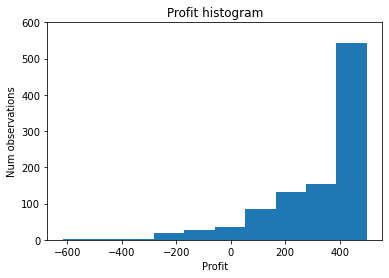

In [20]:
plt.title("Profit histogram")
plt.xlabel("Profit")
plt.ylabel("Num observations")
plt.ylim(0, 600)
plt.hist(profit_sim, density=False);


While `demand` was normally distributed, the resulting profit distribution is definitely **not** normally distributed. I'm sure you've figured out why this histogram has the shape it does and how this relates to the Flaw of Averages.

The `scipy.stats` library can be used to answer typical questions about the distribution of profit.

In [21]:
from scipy import stats

What's the chance we have a negative profit?

In [22]:
print(stats.percentileofscore(profit_sim, 0) / 100.0)

0.063


In [23]:
# Probability profit is between -200, 200
print((stats.percentileofscore(profit_sim, 200) - stats.percentileofscore(profit_sim, -200)) / 100.0)

0.1895


We can create an empirical cumulative distribution function for `profit_sim` and then use it to customize plots.

In [24]:
profit_cdf = stats.cumfreq(profit_sim)

In [25]:
x = profit_cdf.lowerlimit + np.linspace(0, profit_cdf.binsize * profit_cdf.cumcount.size,
                                 profit_cdf.cumcount.size)

(-679.5833333333334, 562.0833333333329)

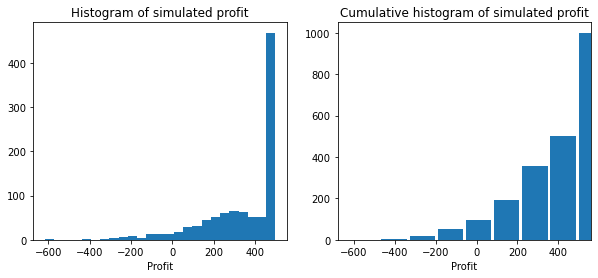

In [26]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(profit_sim, bins=25)
ax1.set_title('Histogram of simulated profit')
ax1.set_xlabel('Profit')
ax2.bar(x, profit_cdf.cumcount, width=profit_cdf.binsize)
ax2.set_title('Cumulative histogram of simulated profit')
ax2.set_xlabel('Profit')
ax2.set_xlim([x.min(), x.max()])

### Multiple Uncertain Inputs

Again, note how we used a list comprehension to evaluate profit for each demand realization. If we have multiple random inputs we **cannot** use multiple `for` statements as we don't want the cross product of the random number vectors. Instead we'd need to `zip` them up into tuples. Here's a simple example of tuple zipping.

In [27]:
alpha = [1, 2, 3]
beta = [10, 20, 30]

for t in zip(alpha, beta):
    print(t)

(1, 10)
(2, 20)
(3, 30)


Assume we have some uncertainty around both the `unit_cost` and `unit_refund` values. Let's model our uncertainty with uniform distributions:

* `unit_cost` $\sim U(7.00, 8.00)$
* `unit_refund` $\sim U(2.00, 3.00)$

In [28]:
unit_cost_sim = rg.uniform(7.0, 8.0, 1000)
unit_refund_sim = rg.uniform(2.0, 3.0, 1000)

rv_uniform = stats.uniform(loc=7.0, scale=1.0)

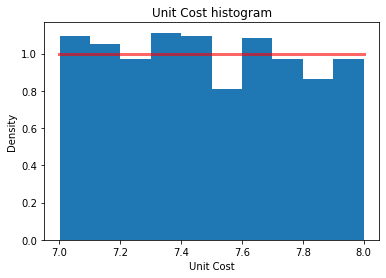

In [29]:
plt.title("Unit Cost histogram")
plt.xlabel("Unit Cost")
plt.ylabel("Density")
plt.hist(unit_cost_sim, density=True);

x_uniform = np.linspace(7.0, 8.0, 100)

plt.plot(x_uniform, rv_uniform.pdf(x_uniform),
       'r-', lw=3, alpha=0.6, label='Uniform pdf');

Let's zip the three random vectors into tuples.

In [30]:
random_inputs = zip(demand_sim, unit_cost_sim, unit_refund_sim)

In [31]:
profit_sim_2 = pd.Series([(bookstore_profit(uc, selling_price, uf, order_quantity, d)) 
               for (d, uc, uf) in random_inputs])

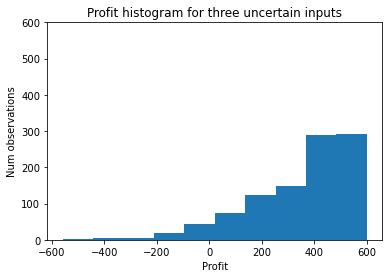

In [32]:
plt.title("Profit histogram for three uncertain inputs")
plt.xlabel("Profit")
plt.ylabel("Num observations")
plt.ylim(0, 600)
plt.hist(profit_sim_2, density=False);

The additional uncertainty has made the distribution somewhat less extreme in the right tail (it's still highly skewed).

### Multiple scenarios: profit vs order quantity
In addition to random inputs, we often have other inputs we want to vary over a defined range - i.e. scenarios. Just as we did Part 1 of this series with data tables, we can use a list comprehension to iterate over the scenarios.

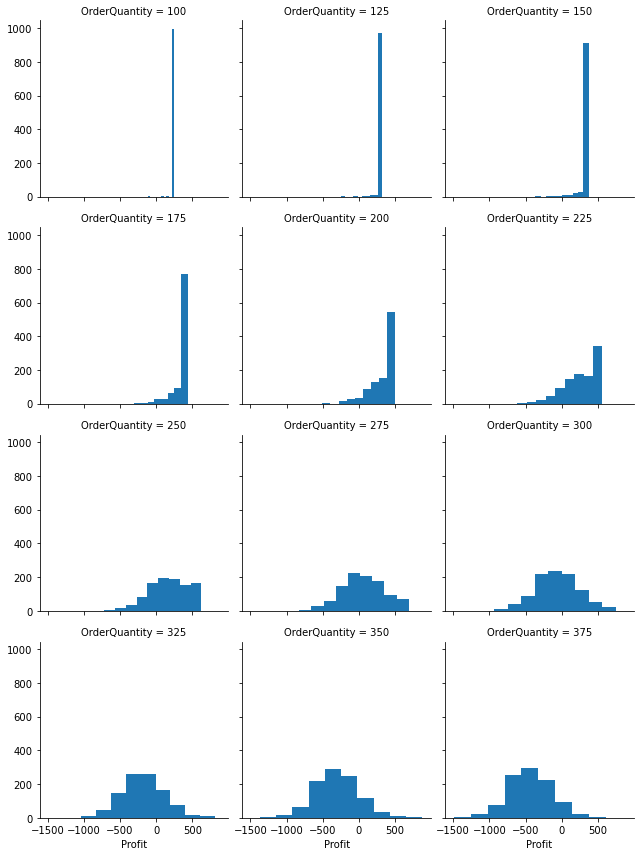

In [33]:
# Create array of order quantities (the scenarios) 
order_quantity_range = np.arange(100, 400, 25)

# Create simulation data table 
sim_table_1 = [(oq, bookstore_profit(unit_cost, selling_price, unit_refund, oq, d)) 
                    for oq in order_quantity_range for d in demand_sim]

# Convert to dataframe
stbl_1_df = pd.DataFrame(sim_table_1, columns=['OrderQuantity', 'Profit'])

# Plot the results
profit_histo_g = sns.FacetGrid(stbl_1_df, col="OrderQuantity", sharey=True, col_wrap=3)
profit_histo_g = profit_histo_g.map(plt.hist, "Profit")

Another way to compare the profit distributions across order quantities is to use boxplots.

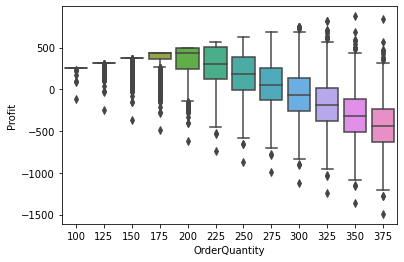

In [34]:
profit_box_g = sns.boxplot(x="OrderQuantity", y="Profit", data=stbl_1_df)

## Repeat simulation using OO approach
Just as we leveraged our non-OO data table approach for simulation, let's do the same for the OO version. We should be able to use scikit-learn's `ParameterGrid` function for optional scenario generation (think RiskSimTable if you've used @Risk). We don't want to use `ParameterGrid` for the random inputs as we don't want all combinations of them - we just want to evaluate one replication per row. We'll use the same random vectors that we created above. The basic initial design of our `simulate` function will be based on the following:

* The first argument will be a model object (i.e. something like the `BookstoreModel` model) that contains an `update` method. Soon, we should add an abstract `Model` class from which specific models such as the `BookstoreModel` class can be created. The abstract class will contain the `update` method.
* The random inputs will be passed in as a dictionary whose keys are the input variables being modeled as random and who values are an iterable representing the draws from some probability distribution. Structurally, this is similar to how inputs are specified in the `data_table` function.
* We can optionally pass in a dictionary of scenario inputs. This is exactly like the `data_table` variable input.
     - If no scenario input dictionary is passed in, a single simulation scenario is run using the current input values in the model object,
     - If a scenario input dictionary is passed in, then a simulation scenario is run for every combination of parameters in the dictionary. Again, this is just like we do in the `data_table` function.
* The output will be a set of dictionaries containing dataframes of simulation output as well standard summary stats and plots.

In Parts 1 and 2 of this series we created the `BookstoreModel` class as well as `data_table` and `goal_seek` functions. Instead of repeating those definitions here, I've moved their code into **whatif.py** and we can just import it. 

In [35]:
from whatif import BookstoreModel

Let's reset our base input values and then create a new `BookstoreModel` object with these property values.

In [36]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

order_quantity = 200

demand_mean = 193
demand_sd = 40

demand = demand_mean

In [37]:
model2 = BookstoreModel(unit_cost=unit_cost, 
                        selling_price=selling_price,
                        unit_refund=unit_refund,
                        order_quantity=order_quantity,
                        demand=demand)

Again, we will model three of our inputs, `demand`, `unit_cost`, and `unit_refund` as random variables. All three were creatd earlier in the notebook, but here they are again. Let's just do 100 scenarios to reduce the number of output rows for viewing.

In [38]:
num_reps = 100
demand_sim = rg.normal(demand_mean, demand_sd, num_reps)
unit_cost_sim = rg.uniform(7.0, 8.0, num_reps)
unit_refund_sim = rg.uniform(2.0, 3.0, num_reps)

random_inputs = {'demand': demand_sim,
                'unit_cost': unit_cost_sim,
                'unit_refund': unit_refund_sim}

It's also perfectly fine to not pre-generate the random variates. If we decide to specify the inputs in this way (next cell), then our `simulate` function should include a boolean input that specifies whether the raw simulated input values should be saved and returned as part of its output.

In [39]:
random_inputs = {'demand': rg.normal(demand_mean, demand_sd, num_reps),
                'unit_cost': rg.uniform(7.0, 8.0, num_reps),
                'unit_refund': rg.uniform(2.0, 3.0, num_reps)}

For the scenario inputs, we'll use the range of order quantity values used in the `data_table` examples.

In [40]:
scenario_inputs = {'order_quantity': np.arange(70, 321, 50)}
list(ParameterGrid(scenario_inputs))

[{'order_quantity': 70},
 {'order_quantity': 120},
 {'order_quantity': 170},
 {'order_quantity': 220},
 {'order_quantity': 270},
 {'order_quantity': 320}]

We'll stick with `profit` as the only output variable for now.

In [41]:
sim_outputs = ['profit']

Here's my first version of a `simulate` function.

In [42]:
def simulate(model, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
    '''Simulate model for one or more scenarios

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    random_intputs : dict of str to sequence of random variates
        Keys are stochastic input variable names and values are sequence of $n$ random variates, where $n$ is the number of simulation replications
    outputs : list of str
        List of output variable names
    scenario_inputs : optional (default is None), dict of str to sequence
        Keys are deterministic input variable names and values are sequence of values for each scenario for this variable. Is consumed by
        scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    keep_random_inputs : optional (default is False), boolean
        If True, all the random input variates are included in the results dataframe

    Returns
    -------
    results_df : pandas DataFrame
        Values of all outputs for each simulation replication. If `scenario_inputs` is not None, then this is also for every combination of scenario inputs
    '''
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # Update clone with random_inputs
    model_clone.update(random_inputs)
    
    # Store raw simulation input values if desired
    if keep_random_inputs:
        scenario_base_vals = vars(model_clone)
    else:
        scenario_base_vals = vars(model)
    
    # Initialize output counters and containers
    scenario_num = 0
    scenario_results = []
    
    # Check if multiple scenarios
    if scenario_inputs is not None:
        # Create parameter grid for scenario inputs
        sim_param_grid = list(ParameterGrid(scenario_inputs))
        
        # Scenario loop
        for params in sim_param_grid:
            model_clone.update(params)
            # Initialize scenario related outputs
            result = {}
            scenario_vals = copy.copy(params)
            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = scenario_vals
            raw_output = {}
            
            # Output measure loop
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array
            
            # Gather results for this scenario
            result['output'] = raw_output
            scenario_results.append(result)
            scenario_num += 1
                
        return scenario_results

    else:
        # Similar logic to above, but only a single scenario
        results = []
        result = {}

        result['scenario_base_vals'] = scenario_base_vals
        result['scenario_num'] = scenario_num
        result['scenario_vals'] = {}
        
        raw_output = {}
        for output_name in outputs:
            output_array = getattr(model_clone, output_name)()
            raw_output[output_name] = output_array
            
        result['output'] = raw_output  
        results.append(result)

        return results

Let's run the simulation.

In [43]:
model2_results = simulate(model2, random_inputs, sim_outputs, scenario_inputs)

The output (for now) is a list of dictionaries. Each dictionary corresponds to one scenario (in this case, one value of `order_quantity`. Let's pluck out one scenario near the middle of the order quantity values and explore the outputs.

In [44]:
which_scenario = 4

# What are the keys in the output dictionaries
model2_results[which_scenario].keys()

dict_keys(['scenario_base_vals', 'scenario_num', 'scenario_vals', 'output'])

In [45]:
model2_results[which_scenario]['scenario_vals']

{'order_quantity': 270}

In [46]:
for scenario in model2_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], scenario['output']['profit'].mean())

0 {'order_quantity': 70} 176.0191921065434
1 {'order_quantity': 120} 299.6121899248544
2 {'order_quantity': 170} 381.3838755407154
3 {'order_quantity': 220} 287.56197705166164
4 {'order_quantity': 270} 17.00942728215051
5 {'order_quantity': 320} -306.2002083301332


Let's take a look at an entry from one of the scenario dictionaries.

In [47]:
model2_results[which_scenario]

{'scenario_base_vals': {'unit_cost': 7.5,
  'selling_price': 10.0,
  'unit_refund': 2.5,
  'order_quantity': 200,
  'demand': 193},
 'scenario_num': 4,
 'scenario_vals': {'order_quantity': 270},
 'output': {'profit': array([  94.07848039,   10.29745358,  235.96489009, -436.72652984,
         -226.9675955 ,  601.45820208,  293.64935644, -425.72328478,
         -390.00020874,  -15.59715502,  306.2150294 , -329.35451825,
          661.32783105,  -36.51672742,  230.13464279, -323.27742095,
          505.40223752,  337.80405457, -119.90157877,  132.33787233,
         -901.24678476,  390.99625756, -255.71597319,  461.87713384,
         -313.95088686,  210.3540985 ,  366.73915719,  243.41026106,
          646.59828596, -137.23342344, -171.73200896,  181.77906894,
          142.5739788 ,  114.81682308,   28.4746822 ,   45.60270247,
         -438.76329113, -212.90798302,  -34.84212884,  -29.78550324,
          265.03280914,  220.44086959, -224.92077887, -559.73996413,
          684.40416776,  5

Let's write a gather results function to turn results object into analysis ready DataFrame.

In [48]:
def get_sim_results_df(results):
    
    dfs = []    
    for r in model2_results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val
            
        dfs.append(df)

    results_df = pd.concat(dfs)
    
    return results_df

In [49]:
model2_results_df = get_sim_results_df(model2_results)

In [50]:
model2_results_df

,profit,scenario_num,order_quantity
0,170.275117,0,70
1,164.192202,0,70
2,167.876925,0,70
3,160.018106,0,70
4,181.568184,0,70
...,...,...,...
95,-732.460739,5,320
96,-306.229201,5,320
97,-106.301086,5,320
98,-644.780031,5,320


Now it's easy to do plots like the following:

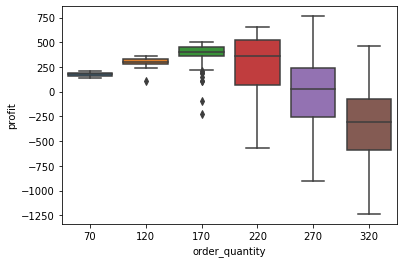

In [51]:
sns.boxplot(x="order_quantity", y="profit", data=model2_results_df);

... or this:

In [ ]:
profit_histo_g2 = sns.FacetGrid(model2_results_df, col='order_quantity', sharey=True, col_wrap=3)
profit_histo_g2 = profit_histo_g2.map(plt.hist, "profit")

... and statistical summaries like this:

In [ ]:
model2_results_df.groupby(['scenario_num'])['profit'].describe()

Lot's more to do, but let's stop here for this post. The basic design seems ok and we can build on this in future installments.

## Wrap up and next steps
We have added a basic `simulate` function to our `data_table` and `goal_seek` functions. Python is proving to be quite nice for doing Excel-style "what if?" analysis. 

In Part 4 of this series, we'll make some improvements and do some clean-up on our classes and functions. We'll move everything into a single **whatif.py** module and learn how to create a Python package to make it easy to use and share our new functions. We'll try out our package on a new model and sketch out some ideas for future enhancements to the package. It's important we also start creating some basic documentation and a user guide.